### Impact schepcorner
In deze notebook gaan we na wat de impact is van de schepcorner in het minivoetbal. Hoe uitslagbepalend is hij. Leidt het missen van een schepcorner tot een negatieve sfeer. 

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
### data inladen
wedstrijden_cleaned = pd.read_excel('../../Data/Silver/wedstrijden_cleaned.xlsx')
corners_cleaned = pd.read_excel('../../Data/Silver/cornerballen_cleaned.xlsx')

In [81]:
merged_df = pd.merge(wedstrijden_cleaned, corners_cleaned, on='wedstrijd_id', how='left')

Aantal matchen zonder/met schepcorner

In [82]:
aantal_wedstrijden = wedstrijden_cleaned.shape[0]
aantal_wedstrijden_met_corners = corners_cleaned["wedstrijd_id"].nunique()


In [83]:
print(f"Aantal wedstrijden: {aantal_wedstrijden}")
print(f"Aantal wedstrijden met corners: {aantal_wedstrijden_met_corners}")
print(f"Aantal wedstrijden zonder corners: {aantal_wedstrijden - aantal_wedstrijden_met_corners}")
print(f"Percentage wedstrijden met corners: {aantal_wedstrijden_met_corners / aantal_wedstrijden * 100:.2f}%")

Aantal wedstrijden: 231
Aantal wedstrijden met corners: 230
Aantal wedstrijden zonder corners: 1
Percentage wedstrijden met corners: 99.57%


### strengste impact
veranderen van uitkomst van 1 schepcorner verandert resultaat van match, andere winnaar/gelijkspel

In [84]:
# strengste impact, uitkomst van 1 schepcorner in de match veranderen, is bepalend
def schepcorner_impact(df):
    results = []

    for match_id, match_data in df.groupby("wedstrijd_id"):
        uitslag_str = match_data["uitslag"].iloc[0]  # iloc selecteert eerste rij van match_data
        score_thuis, score_uit = map(int, uitslag_str.split("v"))  
        score_verschil = abs(score_thuis - score_uit)

        # Controleer of er een schepcorner is (indien alle is_thuisploeg en goal NA zijn, dan geen schepcorner)
        heeft_schepcorner = match_data["goal"].notna().any()

        if not heeft_schepcorner:
            results.append((match_id, False))  # Geen schepcorner? Geen impact.
            continue  

        # Gelijkspel: altijd impact als er een schepcorner was
        if score_thuis == score_uit:
            results.append((match_id, True))
            continue

        # Bepaal winnaar en verliezer
        if score_thuis > score_uit:
            winnaar = 1
            verliezer = 0
        else:
            winnaar = 0
            verliezer = 1

        # Controleer of winnaar minstens één schepcorner scoorde
        winnaar_heeft_gescoord = ((match_data["is_thuisploeg"] == winnaar) & (match_data["goal"] == 1)).any()

        # Controleer of verliezer minstens één schepcorner miste
        verliezer_heeft_gemist = ((match_data["is_thuisploeg"] == verliezer) & (match_data["goal"] == 0)).any()

        # Strikte voorwaarde: maximaal 1 verschil en schepcorner moet impact hebben
        if score_verschil == 1 and (winnaar_heeft_gescoord or verliezer_heeft_gemist):
            results.append((match_id, True))
        else:
            results.append((match_id, False))

    return pd.DataFrame(results, columns=["wedstrijd_id", "schepcorner_impact"])

In [85]:
strengste_impact_df = schepcorner_impact(merged_df)
aantal_matchen_met_strengste_impact = strengste_impact_df["schepcorner_impact"].sum()

In [86]:
print(f"Aantal wedstrijden met strengste impact: {aantal_matchen_met_strengste_impact}")
print(f"Percentage wedstrijden met strengste impact: {aantal_matchen_met_strengste_impact / aantal_wedstrijden * 100:.2f}%")

Aantal wedstrijden met strengste impact: 59
Percentage wedstrijden met strengste impact: 25.54%


In [87]:
# controle
wedstrijd_ids_strengste_impact = strengste_impact_df[strengste_impact_df["schepcorner_impact"] == 1]["wedstrijd_id"].tolist()
wedstrijd_ids_strengste_impact 

[6,
 12,
 16,
 18,
 26,
 29,
 30,
 34,
 37,
 40,
 42,
 44,
 45,
 46,
 49,
 50,
 62,
 66,
 68,
 71,
 84,
 88,
 93,
 100,
 111,
 114,
 115,
 116,
 121,
 126,
 127,
 147,
 150,
 152,
 153,
 156,
 165,
 166,
 167,
 174,
 176,
 177,
 181,
 183,
 185,
 187,
 190,
 193,
 198,
 200,
 201,
 205,
 208,
 209,
 216,
 219,
 224,
 229,
 230]

In [88]:
merged_df[merged_df["wedstrijd_id"].isin(wedstrijd_ids_strengste_impact)][["wedstrijd_id", "uitslag", "is_thuisploeg", "goal"]]

,wedstrijd_id,uitslag,is_thuisploeg,goal
13,6,7v8,1.0,1.0
14,6,7v8,1.0,1.0
15,6,7v8,0.0,1.0
29,12,5v6,1.0,1.0
30,12,5v6,0.0,1.0
...,...,...,...,...
595,229,6v5,1.0,1.0
596,230,8v8,1.0,1.0
597,230,8v8,1.0,1.0
598,230,8v8,0.0,1.0


### impact op matchuitslagen wanneer er geen schepcorners zouden zijn, of alle gemist zouden zijn.

In [89]:
def bepaal_winnaar_verliezer(uitslag_str):
    thuis_score, uit_score = map(lambda x: int(float(x)), uitslag_str.split('v'))
    
    if thuis_score > uit_score:
        return 1  # thuisploeg wint
    elif uit_score > thuis_score:
        return 0  # uitploeg wint
    else:
        return None  # gelijkspel


In [90]:
def bereken_impact_zonder_schepcorner(df):
    impact_lijst = []

    for wedstrijd_id, match_data in df.groupby("wedstrijd_id"):
        uitslag_str = match_data["uitslag"].iloc[0]
        
        # Bepaal het aantal schepcorner-goals per ploeg
        goals_thuis = match_data[match_data["is_thuisploeg"] == 1]["goal"].sum()
        goals_uit = match_data[match_data["is_thuisploeg"] == 0]["goal"].sum()

        # Bereken aangepaste score
        thuis_score, uit_score = map(int, uitslag_str.split('v'))
        nieuwe_thuis = thuis_score - goals_thuis
        nieuwe_uit = uit_score - goals_uit

        # Vergelijk oorspronkelijke en aangepaste uitslag
        oorspronkelijke = bepaal_winnaar_verliezer(uitslag_str)
        nieuwe = bepaal_winnaar_verliezer(f"{nieuwe_thuis}v{nieuwe_uit}")
        impact = oorspronkelijke != nieuwe

        impact_lijst.append({
            "wedstrijd_id": wedstrijd_id,
            "schepcorner_impact": impact
        })

    return pd.DataFrame(impact_lijst)


In [91]:
impact_zonder_schepcorners = bereken_impact_zonder_schepcorner(merged_df)
aantal_matchen_met_impact_zonder_schepcorner = impact_zonder_schepcorners["schepcorner_impact"].sum()

In [92]:
print(f"Aantal wedstrijden met andere uitslag moesten er geen schepcorners zijn: {aantal_matchen_met_impact_zonder_schepcorner}")
print(f"Percentage wedstrijden met andere uitslag moesten er geen schepcorners zijn: {aantal_matchen_met_impact_zonder_schepcorner / aantal_wedstrijden * 100:.2f}%")

Aantal wedstrijden met andere uitslag moesten er geen schepcorners zijn: 42
Percentage wedstrijden met andere uitslag moesten er geen schepcorners zijn: 18.18%


### impact alle schepcorners gescoord


In [93]:
def bereken_schepcorner_impact_als_alle_gescoord(df):
    impact_lijst = []

    for wedstrijd_id, match_data in df.groupby("wedstrijd_id"):
        uitslag_str = match_data["uitslag"].iloc[0]

        # Aantal gemiste schepcorners per ploeg
        gemist_thuis = ((match_data["is_thuisploeg"] == 1) & (match_data["goal"] == 0)).sum()
        gemist_uit = ((match_data["is_thuisploeg"] == 0) & (match_data["goal"] == 0)).sum()

        # Score aanpassen alsof elke schepcorner werd gescoord
        thuis_score, uit_score = map(int, uitslag_str.split('v'))
        nieuwe_thuis = thuis_score + gemist_thuis
        nieuwe_uit = uit_score + gemist_uit

        # Bepaal winnaar voor en na
        oorspronkelijke = bepaal_winnaar_verliezer(f"{thuis_score}v{uit_score}")
        nieuwe = bepaal_winnaar_verliezer(f"{nieuwe_thuis}v{nieuwe_uit}")
        impact = oorspronkelijke != nieuwe

        impact_lijst.append({
            "wedstrijd_id": wedstrijd_id,
            "schepcorner_impact": impact
        })

    return pd.DataFrame(impact_lijst)


In [94]:
impact_alles_gescoord = bereken_schepcorner_impact_als_alle_gescoord(merged_df)
aantal_matchen_met_impact_alles_gescoord = impact_alles_gescoord["schepcorner_impact"].sum()

In [95]:
print(f"Aantal wedstrijden met andere uitslag moesten alle schepcorners gescoord worden: {aantal_matchen_met_strengste_impact}")
print(f"Percentage wedstrijden met andere uitslag moesten alle schepcorners gescoord worden: {aantal_matchen_met_impact_alles_gescoord / aantal_wedstrijden * 100:.2f}%")

Aantal wedstrijden met andere uitslag moesten alle schepcorners gescoord worden: 59
Percentage wedstrijden met andere uitslag moesten alle schepcorners gescoord worden: 12.12%


### schepcorner impact, minst streng berekend
Hoeveel wedstrijden hebben een andere uitslag, als alle schepcorners van uitkomst kunnen veranderen

In [96]:
def bereken_schepcorner_impact_mild(df):
    impact_lijst = []

    for wedstrijd_id, groep in df.groupby("wedstrijd_id"):
        uitslag_str = groep["uitslag"].iloc[0]

        # Scores omzetten naar integers (voor veiligheid float -> int)
        thuis_score, uit_score = map(int, uitslag_str.split('v'))
        oorspronkelijke = bepaal_winnaar_verliezer(f"{thuis_score}v{uit_score}")

        # Tel gescoorde en gemiste corners
        gescoord_thuis = ((groep["is_thuisploeg"] == 1) & (groep["goal"] == 1)).sum()
        gemist_thuis = ((groep["is_thuisploeg"] == 1) & (groep["goal"] == 0)).sum()
        gescoord_uit = ((groep["is_thuisploeg"] == 0) & (groep["goal"] == 1)).sum()
        gemist_uit = ((groep["is_thuisploeg"] == 0) & (groep["goal"] == 0)).sum()

        # Als gelijkspel en er waren corners → impact
        if oorspronkelijke is None and (gescoord_thuis + gemist_thuis + gescoord_uit + gemist_uit) > 0:
            impact = True
        else:
            if oorspronkelijke == 1:
                min_win = thuis_score - gescoord_thuis
                max_verl = uit_score + gemist_uit
            else:
                min_win = uit_score - gescoord_uit
                max_verl = thuis_score + gemist_thuis

            nieuwe = bepaal_winnaar_verliezer(f"{min_win}v{max_verl}")
            impact = oorspronkelijke != nieuwe

        impact_lijst.append({
            "wedstrijd_id": wedstrijd_id,
            "schepcorner_impact": impact
        })

    return pd.DataFrame(impact_lijst)


In [97]:
impact_mild = bereken_schepcorner_impact_mild(merged_df)
aantal_matchen_met_impact_mild = impact_mild["schepcorner_impact"].sum()

In [98]:
print(f"Aantal wedstrijden met andere uitslag moesten alle schepcorners van uitkomst gewijzigd kunnen worden: {aantal_matchen_met_impact_mild}")
print(f"Percentage wedstrijden met andere uitslag moesten alle schepcorners van uitkomst gewijzigd kunnen worden: {aantal_matchen_met_impact_mild / aantal_wedstrijden * 100:.2f}%")

Aantal wedstrijden met andere uitslag moesten alle schepcorners van uitkomst gewijzigd kunnen worden: 139
Percentage wedstrijden met andere uitslag moesten alle schepcorners van uitkomst gewijzigd kunnen worden: 60.17%


### Nu kunnen we ook checken of corners missen/scoren sleutelmomenten zijn

In [99]:
merged_df.columns

Index(['wedstrijd_id', 'datum', 'niveau', 'uitslag', 'corners_uitslag',
       'klassement_uitslag', 'schepcorner_id', 'ploegnaam',
       'ervaring_schepper', 'ervaring_kopper', 'ervaring_duo', 'is_thuisploeg',
       'kwart', 'is_schepper_bank', 'is_kopper_bank', 'score_voor',
       'schepper_pos_rechts', 'positie', 'kop_verplaatsen_achter',
       'kop_veel_verplaatsen', 'kop_hor_verplaatsen', 'goal'],
      dtype='object')

In [100]:
merged_df[["wedstrijd_id", "uitslag", "schepcorner_id", "is_thuisploeg", "score_voor", "goal"]].head()

,wedstrijd_id,uitslag,schepcorner_id,is_thuisploeg,score_voor,goal
0,1,4v1,1.0,1.0,0v0,1.0
1,1,4v1,2.0,1.0,2v0,0.0
2,1,4v1,3.0,0.0,2v0,0.0
3,2,11v2,4.0,1.0,4v1,0.0
4,2,11v2,5.0,0.0,5v2,0.0


### hypothese, missen schepcorner leidt tot momentum_verlies. 

In [101]:
def bepaal_sleutelmomenten_schepcorners(df):
    sleutelmomenten = []

    for wedstrijd_id, match_data in df.groupby("wedstrijd_id"):
        match_data = match_data.sort_values("schepcorner_id").reset_index(drop=True)

        # Eindscore parsen
        eind_thuis, eind_uit = map(int, match_data["uitslag"].iloc[0].split('v'))

        for i, rij in match_data.iterrows():
            if rij["goal"] != 0:
                continue  # Alleen gemiste schepcorners analyseren

            # Score vóór de corner
            thuis_voor, uit_voor = map(int, rij["score_voor"].split('v'))
            verschil_voor = thuis_voor - uit_voor

            # Score ná de corner: volgende snapshot of eindstand
            if i + 1 < len(match_data):
                thuis_na, uit_na = map(int, match_data.loc[i + 1, "score_voor"].split('v'))
            else:
                thuis_na, uit_na = eind_thuis, eind_uit
            verschil_na = thuis_na - uit_na

            delta = verschil_voor - verschil_na

            # Impact bepalen volgens ploeg
            if rij["is_thuisploeg"] == 1:
                sleutelmoment = delta > 0
            else:
                sleutelmoment = delta < 0

            
            ongewijzigd = int(delta == 0)
            positief_momentum = int((not sleutelmoment) and (not ongewijzigd))

            sleutelmomenten.append({
                "wedstrijd_id": wedstrijd_id,
                "schepcorner_id": rij["schepcorner_id"],
                "negatief_momentum": int(sleutelmoment),
                "ongewijzigd": ongewijzigd,
                "positief_momentum": positief_momentum
            })

    return pd.DataFrame(sleutelmomenten)


In [102]:
impact_missen = bepaal_sleutelmomenten_schepcorners(merged_df)
aantal_neg_mom = impact_missen["negatief_momentum"].sum()
aantal_ongewijzigd = impact_missen["ongewijzigd"].sum()
aantal_pos_mom = impact_missen["positief_momentum"].sum()

In [103]:
print(f"Aantal schepcorners gemist: {merged_df[merged_df['goal'] == 0].shape[0]}")
print(f"Aantal gemiste schepcorners die leiden tot momentum verlies: {aantal_neg_mom}")
print(f"Percentage gemiste schepcorners die leiden tot momentum verlies: {aantal_neg_mom / merged_df[merged_df['goal'] == 0].shape[0] * 100:.2f}%")
print("-" * 50)
print(f"Aantal gemiste schepcorners die leiden tot ongewijzigd momentum: {aantal_ongewijzigd}")
print(f"Percentage gemiste schepcorners die leiden tot ongewijzigd momentum: {aantal_ongewijzigd / merged_df[merged_df['goal'] == 0].shape[0] * 100:.2f}%")
print("-" * 50)
print(f"Aantal gemiste schepcorners die leiden tot momentum winst: {aantal_pos_mom}")
print(f"Percentage gemiste schepcorners die leiden tot momentum winst: {aantal_pos_mom / merged_df[merged_df['goal'] == 0].shape[0] * 100:.2f}%")

Aantal schepcorners gemist: 204
Aantal gemiste schepcorners die leiden tot momentum verlies: 52
Percentage gemiste schepcorners die leiden tot momentum verlies: 25.49%
--------------------------------------------------
Aantal gemiste schepcorners die leiden tot ongewijzigd momentum: 95
Percentage gemiste schepcorners die leiden tot ongewijzigd momentum: 46.57%
--------------------------------------------------
Aantal gemiste schepcorners die leiden tot momentum winst: 57
Percentage gemiste schepcorners die leiden tot momentum winst: 27.94%


In [104]:
def plot_momentum_barchart(aantal_pos_mom, aantal_ongewijzigd, aantal_neg_mom, titel="Momentum na gemiste schepcorners", hoogte=10):
    
    # Data voorbereiden
    totaal = aantal_pos_mom + aantal_ongewijzigd + aantal_neg_mom
    df = pd.DataFrame({
        'momentum': ['Positief', 'Ongewijzigd', 'Negatief'],
        'aantal': [aantal_pos_mom, aantal_ongewijzigd, aantal_neg_mom]
    })
    df['percentage'] = df['aantal'] / totaal * 100

    # Academische stijl instellen
    sns.set_theme(style="whitegrid", font_scale=1.2, rc={
        'axes.edgecolor': 'black',
        'axes.labelweight': 'bold',
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'font.family': 'serif'
    })

    # Plot aanmaken
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(
        data=df,
        x='momentum',
        y='aantal',
        color='grey',
        edgecolor='black'
    )

    # Annotaties toevoegen met percentages
    for i, row in df.iterrows():
        ax.text(i, row['aantal'] + 2, f"{row['percentage']:.2f}%", 
                ha='center', va='bottom', fontsize=11, weight='bold')

    # Titels en labels instellen
    plt.title(titel)
    plt.xlabel('Type momentum')
    plt.ylabel('Aantal schepcorners')
    plt.ylim(0, df["aantal"].max() + hoogte)

    plt.tight_layout()
    plt.show()

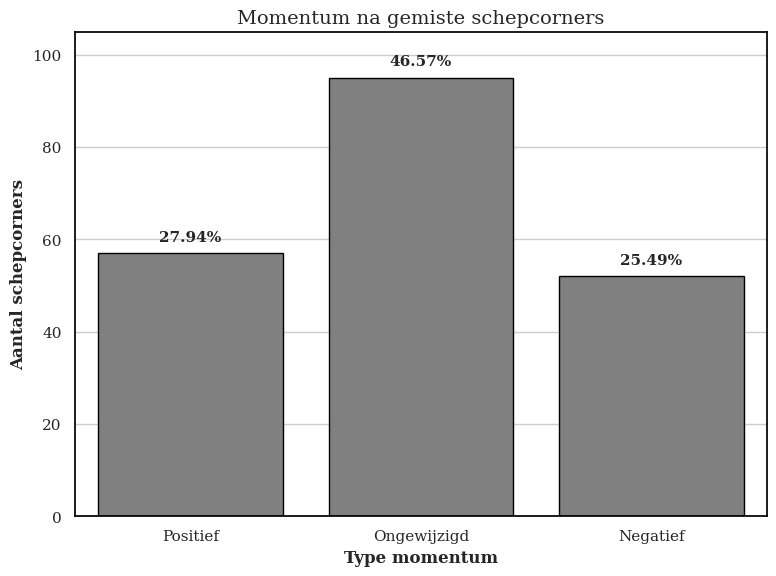

In [105]:
plot_momentum_barchart(aantal_pos_mom, aantal_ongewijzigd, aantal_neg_mom, titel="Momentum na gemiste schepcorners")

### positieve impact na gescoorde corner.

In [106]:
def bepaal_sleutelmomenten_gescoorde_schepcorners(df):
    sleutelmomenten = []

    for wedstrijd_id, groep in df.groupby("wedstrijd_id"):
        groep = groep.sort_values("schepcorner_id").reset_index(drop=True)

        # Eindscore parsen
        eind_thuis, eind_uit = map(int, groep["uitslag"].iloc[0].split('v'))

        for i, rij in groep.iterrows():
            if rij["goal"] != 1:
                continue  # Alleen gescoorde schepcorners analyseren

            # Score vóór de corner, goal direct bijtellen
            thuis_voor, uit_voor = map(int, rij["score_voor"].split('v'))
            if rij["is_thuisploeg"] == 1:
                thuis_voor += 1
            else:
                uit_voor += 1
            verschil_voor = thuis_voor - uit_voor

            # Score ná de corner: volgende snapshot of eindstand
            if i + 1 < len(groep):
                thuis_na, uit_na = map(int, groep.loc[i + 1, "score_voor"].split('v'))
            else:
                thuis_na, uit_na = eind_thuis, eind_uit
            verschil_na = thuis_na - uit_na

            delta = verschil_na - verschil_voor

            # Impact bepalen volgens ploeg
            if rij["is_thuisploeg"] == 1:
                sleutelmoment = delta > 0
            else:
                sleutelmoment = delta < 0

            ongewijzigd = int(delta == 0)
            negatief_momentum = int((not sleutelmoment) and (not ongewijzigd))

            sleutelmomenten.append({
                "wedstrijd_id": wedstrijd_id,
                "schepcorner_id": rij["schepcorner_id"],
                "positief_momentum": int(sleutelmoment),
                "ongewijzigd": ongewijzigd,
                "negatief_momentum": negatief_momentum
            })

    return pd.DataFrame(sleutelmomenten)

In [107]:
impact_scoren = bepaal_sleutelmomenten_gescoorde_schepcorners(merged_df)
aantal_pos_mom_score = impact_scoren["positief_momentum"].sum()
aantal_ongewijzigd_score = impact_scoren["ongewijzigd"].sum()
aantal_neg_mom_score = impact_scoren["negatief_momentum"].sum()

In [108]:
print(f"Aantal schepcorners gemist: {merged_df[merged_df['goal'] == 1].shape[0]}")
print(f"Aantal gescoorde schepcorners die leiden tot momentum boost: {aantal_pos_mom_score}")
print(f"Percentage gescoorde schepcorners die leiden tot momentum boost: {aantal_pos_mom_score / merged_df[merged_df['goal'] == 1].shape[0] * 100:.2f}%")
print("-" * 50)
print(f"Aantal gescoorde schepcorners die leiden tot ongewijzigd momentum: {aantal_ongewijzigd_score}")
print(f"Percentage gescoorde schepcorners die leiden tot ongewijzigd momentum: {aantal_ongewijzigd_score / merged_df[merged_df['goal'] == 1].shape[0] * 100:.2f}%")
print("-" * 50)
print(f"Aantal gescoorde schepcorners die leiden tot momentum verlies: {aantal_neg_mom_score}")
print(f"Percentage gescoorde schepcorners die leiden tot momentum verlies: {aantal_neg_mom_score / merged_df[merged_df['goal'] == 1].shape[0] * 100:.2f}%")

Aantal schepcorners gemist: 399
Aantal gescoorde schepcorners die leiden tot momentum boost: 143
Percentage gescoorde schepcorners die leiden tot momentum boost: 35.84%
--------------------------------------------------
Aantal gescoorde schepcorners die leiden tot ongewijzigd momentum: 147
Percentage gescoorde schepcorners die leiden tot ongewijzigd momentum: 36.84%
--------------------------------------------------
Aantal gescoorde schepcorners die leiden tot momentum verlies: 109
Percentage gescoorde schepcorners die leiden tot momentum verlies: 27.32%


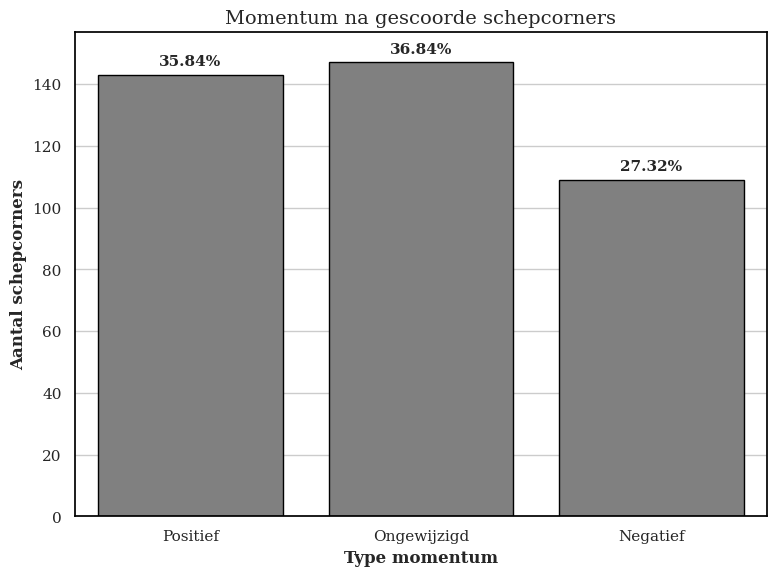

In [109]:
plot_momentum_barchart(aantal_pos_mom_score, aantal_ongewijzigd_score, aantal_neg_mom_score, titel="Momentum na gescoorde schepcorners", hoogte=10)

In [110]:
### Algemeen momentum, kunnen we gebruiken om significantie te checken
def bepaal_algemeen_momentum_schepcorners(df):
    resultaten = []

    for wedstrijd_id, groep in df.groupby("wedstrijd_id"):
        groep = groep.sort_values("schepcorner_id").reset_index(drop=True)

        # Eindscore
        eind_thuis, eind_uit = map(int, groep["uitslag"].iloc[0].split('v'))

        for i, rij in groep.iterrows():
            if pd.isna(rij["score_voor"]):
                continue  # of: sla dit rijtje over
            thuis_voor, uit_voor = map(int, rij["score_voor"].split('v'))

            # Bij doelpunt: tel de goal direct bij score_voor
            if rij["goal"] == 1:
                if rij["is_thuisploeg"] == 1:
                    thuis_voor += 1
                else:
                    uit_voor += 1

            verschil_voor = thuis_voor - uit_voor

            # Score ná de schepcorner: volgende snapshot of eindstand
            if i + 1 < len(groep):
                thuis_na, uit_na = map(int, groep.loc[i + 1, "score_voor"].split('v'))
            else:
                thuis_na, uit_na = eind_thuis, eind_uit

            verschil_na = thuis_na - uit_na

            # Delta
            delta = verschil_na - verschil_voor

            # Positief momentum: score verbetert
            if rij["is_thuisploeg"] == 1:
                positief_momentum = delta > 0
            else:
                positief_momentum = delta < 0

            # Extra categorisatie
            ongewijzigd = int(delta == 0)
            negatief_momentum = int((not positief_momentum) and (not ongewijzigd))

            resultaten.append({
                "wedstrijd_id": wedstrijd_id,
                "schepcorner_id": rij["schepcorner_id"],
                "positief_momentum": int(positief_momentum),
                "ongewijzigd": ongewijzigd,
                "negatief_momentum": negatief_momentum
            })

    return pd.DataFrame(resultaten)


In [111]:
algemeen_mom = bepaal_algemeen_momentum_schepcorners(merged_df)

In [112]:
alg_pos_mom = algemeen_mom["positief_momentum"].sum()
alg_ongewijzigd = algemeen_mom["ongewijzigd"].sum()
alg_neg_mom = algemeen_mom["negatief_momentum"].sum()
print(f"Aantal schepcorners met positief momentum: {alg_pos_mom}")
print(f"Percentage schepcorners met positief momentum: {alg_pos_mom / algemeen_mom.shape[0] * 100:.2f}%")
print("-" * 50)
print(f"Aantal schepcorners met ongewijzigd momentum: {alg_ongewijzigd}")
print(f"Percentage schepcorners met ongewijzigd momentum: {alg_ongewijzigd / algemeen_mom.shape[0] * 100:.2f}%")
print("-" * 50)
print(f"Aantal schepcorners met negatief momentum: {alg_neg_mom}")
print(f"Percentage schepcorners met negatief momentum: {alg_neg_mom / algemeen_mom.shape[0] * 100:.2f}%")

Aantal schepcorners met positief momentum: 200
Percentage schepcorners met positief momentum: 33.17%
--------------------------------------------------
Aantal schepcorners met ongewijzigd momentum: 242
Percentage schepcorners met ongewijzigd momentum: 40.13%
--------------------------------------------------
Aantal schepcorners met negatief momentum: 161
Percentage schepcorners met negatief momentum: 26.70%


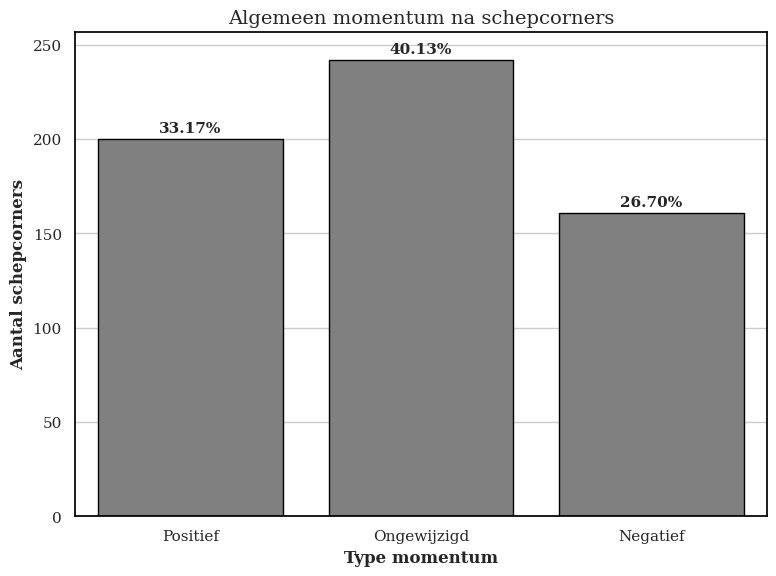

In [113]:
plot_momentum_barchart(alg_pos_mom, alg_ongewijzigd, alg_neg_mom, titel="Algemeen momentum na schepcorners", hoogte=15)

In [114]:
### verklaring meer positief momentum in algemeen, winnaars hebben meer schepcorners en scoren dus meer => meer positief momentum
# zie einde statistiek

### Heeft momentum voor een schepcorner effect op de uitkomst
en verschil checken momentum voor vs na schepcorner

In [115]:
merged_df[['uitslag_thuis', 'uitslag_uit']] = merged_df['uitslag'].str.split('v', expand=True)
merged_df[['score_voor_thuis', 'score_voor_uit']] = merged_df['score_voor'].str.split('v', expand=True)

# Convert to numeric
cols_to_convert = [
    
    'uitslag_thuis', 'uitslag_uit',
    'score_voor_thuis', 'score_voor_uit'
]

for col in cols_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce').astype('Int64')


In [116]:
momentum_df = merged_df[["wedstrijd_id", 'uitslag_thuis', 'uitslag_uit','score_voor_thuis', 'score_voor_uit', "is_thuisploeg", "goal"]].copy()
momentum_df = momentum_df.dropna(subset=["is_thuisploeg"])


In [117]:
# Step 1: shift scores and goal flag
momentum_df["prev_score_thuis_raw"] = momentum_df.groupby("wedstrijd_id")["score_voor_thuis"].shift(1)
momentum_df["prev_score_uit_raw"]   = momentum_df.groupby("wedstrijd_id")["score_voor_uit"].shift(1)
momentum_df["prev_goal"]            = momentum_df.groupby("wedstrijd_id")["goal"].shift(1)
momentum_df["prev_is_thuis"]        = momentum_df.groupby("wedstrijd_id")["is_thuisploeg"].shift(1)

# Step 2: start with raw values
momentum_df["prev_score_thuis"] = momentum_df["prev_score_thuis_raw"]
momentum_df["prev_score_uit"]   = momentum_df["prev_score_uit_raw"]

# Step 3: correct the score if a goal was scored last time
mask_thuis_scored = (momentum_df["prev_goal"] == 1) & (momentum_df["prev_is_thuis"] == 1)
mask_uit_scored   = (momentum_df["prev_goal"] == 1) & (momentum_df["prev_is_thuis"] == 0)

# Add back the goal
momentum_df.loc[mask_thuis_scored, "prev_score_thuis"] += 1
momentum_df.loc[mask_uit_scored,   "prev_score_uit"]   += 1

# game always starts at 0-0
momentum_df["prev_score_thuis"] = momentum_df["prev_score_thuis"].fillna(0)
momentum_df["prev_score_uit"]   = momentum_df["prev_score_uit"].fillna(0)


In [118]:
# Goals scored since last schepcorner
momentum_df["goals_since_thuis"] = momentum_df["score_voor_thuis"] - momentum_df["prev_score_thuis"]
momentum_df["goals_since_uit"]   = momentum_df["score_voor_uit"]   - momentum_df["prev_score_uit"]


In [119]:
momentum_df[["prev_score_thuis", "prev_score_uit", "goals_since_thuis", "goals_since_uit"]].isna().sum()

prev_score_thuis     0
prev_score_uit       0
goals_since_thuis    0
goals_since_uit      0
dtype: int64

In [121]:

def compute_momentum_value(row):
    if row["is_thuisploeg"] == 1:
        my_goals = row["goals_since_thuis"]
        opponent_goals = row["goals_since_uit"]
    else:
        my_goals = row["goals_since_uit"]
        opponent_goals = row["goals_since_thuis"]
    
    if my_goals > opponent_goals:
        return 1
    elif my_goals < opponent_goals:
        return -1
    else:
        return 0

# Apply row-wise
momentum_df["momentum_voor"] = momentum_df.apply(compute_momentum_value, axis=1)


In [125]:
momentum_df.head(20)

,wedstrijd_id,uitslag_thuis,uitslag_uit,score_voor_thuis,score_voor_uit,is_thuisploeg,goal,prev_score_thuis_raw,prev_score_uit_raw,prev_goal,prev_is_thuis,prev_score_thuis,prev_score_uit,goals_since_thuis,goals_since_uit,momentum_voor,momentum_na
0,1,4,1,0,0,1.0,1.0,<NA>,<NA>,NaN,NaN,0,0,0,0,0,1.0
1,1,4,1,2,0,1.0,0.0,0,0,1.0,1.0,1,0,1,0,1,0.0
2,1,4,1,2,0,0.0,0.0,2,0,0.0,1.0,2,0,0,0,0,NaN
3,2,11,2,4,1,1.0,0.0,<NA>,<NA>,NaN,NaN,0,0,4,1,1,0.0
4,2,11,2,5,2,0.0,0.0,4,1,0.0,1.0,4,1,1,1,0,-1.0
5,2,11,2,11,2,0.0,0.0,5,2,0.0,0.0,5,2,6,0,-1,NaN
6,3,4,6,2,3,1.0,0.0,<NA>,<NA>,NaN,NaN,0,0,2,3,-1,0.0
7,3,4,6,2,3,0.0,1.0,2,3,0.0,1.0,2,3,0,0,0,1.0
8,3,4,6,3,4,1.0,1.0,2,3,1.0,0.0,2,4,1,0,1,1.0
9,3,4,6,4,5,0.0,1.0,3,4,1.0,1.0,4,4,0,1,1,NaN


In [124]:
momentum_df["momentum_na"] = momentum_df.groupby("wedstrijd_id")["momentum_voor"].shift(-1)

In [128]:
#### fill na's

def fill_last_momentum_na(row):
    if not pd.isna(row["momentum_na"]):
        return row["momentum_na"]  # keep existing value

    # Adjust current score for this schepcorner
    score_thuis = row["score_voor_thuis"]
    score_uit   = row["score_voor_uit"]

    # If this schepcorner was scored, add goal to appropriate team
    if row["goal"] == 1:
        if row["is_thuisploeg"] == 1:
            score_thuis += 1
        else:
            score_uit += 1

    # Goals scored after this schepcorner
    goals_after_thuis = row["uitslag_thuis"] - score_thuis
    goals_after_uit   = row["uitslag_uit"] - score_uit

    # Compare goals after schepcorner
    if row["is_thuisploeg"] == 1:
        my_goals = goals_after_thuis
        opp_goals = goals_after_uit
    else:
        my_goals = goals_after_uit
        opp_goals = goals_after_thuis

    if my_goals > opp_goals:
        return 1
    elif my_goals < opp_goals:
        return -1
    else:
        return 0

# Apply the function
momentum_df["momentum_na"] = momentum_df.apply(fill_last_momentum_na, axis=1)


In [131]:
momentum_df.columns

Index(['wedstrijd_id', 'uitslag_thuis', 'uitslag_uit', 'score_voor_thuis',
       'score_voor_uit', 'is_thuisploeg', 'goal', 'prev_score_thuis_raw',
       'prev_score_uit_raw', 'prev_goal', 'prev_is_thuis', 'prev_score_thuis',
       'prev_score_uit', 'goals_since_thuis', 'goals_since_uit',
       'momentum_voor', 'momentum_na'],
      dtype='object')

In [132]:
momentum_df[['wedstrijd_id', 'uitslag_thuis', 'uitslag_uit', 'score_voor_thuis','score_voor_uit', 'is_thuisploeg', "goal", 'momentum_voor', 'momentum_na']].head(10)

,wedstrijd_id,uitslag_thuis,uitslag_uit,score_voor_thuis,score_voor_uit,is_thuisploeg,goal,momentum_voor,momentum_na
0,1,4,1,0,0,1.0,1.0,0,1.0
1,1,4,1,2,0,1.0,0.0,1,0.0
2,1,4,1,2,0,0.0,0.0,0,-1.0
3,2,11,2,4,1,1.0,0.0,1,0.0
4,2,11,2,5,2,0.0,0.0,0,-1.0
5,2,11,2,11,2,0.0,0.0,-1,0.0
6,3,4,6,2,3,1.0,0.0,-1,0.0
7,3,4,6,2,3,0.0,1.0,0,1.0
8,3,4,6,3,4,1.0,1.0,1,1.0
9,3,4,6,4,5,0.0,1.0,1,0.0


In [ ]:
momentum_df["momentum_delta"] = momentum_df["momentum_na"] - momentum_df["momentum_voor"]


In [134]:
# Group by momentum_voor and aggregate counts and goals
momentum_summary = (
    momentum_df
    .groupby("momentum_voor")
    .agg(
        total_corners=("goal", "count"),        # total schepcorners
        total_goals=("goal", "sum")             # total goals from corners
    )
    .reset_index()
)

# Calculate score percentage
momentum_summary["score_percentage"] = momentum_summary["total_goals"] / momentum_summary["total_corners"]


In [135]:
momentum_summary

,momentum_voor,total_corners,total_goals,score_percentage
0,-1,186,126.0,0.677419
1,0,218,140.0,0.642202
2,1,199,133.0,0.668342


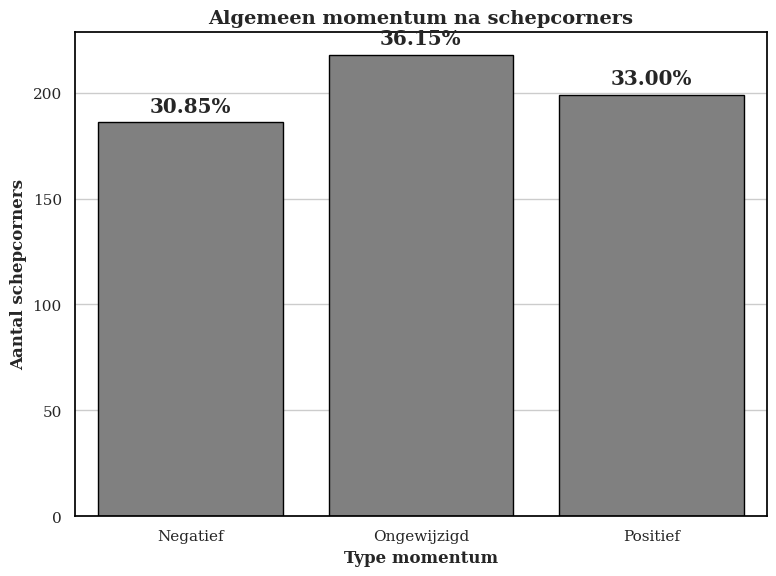

In [136]:
momentum_labels = {
    -1: "Negatief",
     0: "Ongewijzigd",
     1: "Positief"
}
momentum_summary["momentum_label"] = momentum_summary["momentum_voor"].map(momentum_labels)

# Academic style again
sns.set_theme(style="whitegrid", font_scale=1.2, rc={
    'axes.edgecolor': 'black',
    'axes.labelweight': 'bold',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'font.family': 'serif'
})

# Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=momentum_summary,
    x='momentum_label',
    y='total_corners',
    color='grey',
    edgecolor='black'
)

# Add percentages on top of bars
total = momentum_summary["total_corners"].sum()
for i, row in momentum_summary.iterrows():
    percentage = row["total_corners"] / total * 100
    ax.text(i, row["total_corners"] + 5, f"{percentage:.2f}%", ha='center', fontweight='bold')

# Titles and labels
ax.set_xlabel("Type momentum", weight='bold')
ax.set_ylabel("Aantal schepcorners", weight='bold')
ax.set_title("Algemeen momentum na schepcorners", weight='bold')

plt.tight_layout()
plt.show()

In [138]:
def momentum_delta_fixen(delta):
    if delta>0:
        return 1
    elif delta < 0:
        return -1
    else:
        return 0

In [139]:
momentum_df["momentum_delta"] = momentum_df["momentum_delta"].apply(momentum_delta_fixen)

In [140]:
# Group by momentum_voor and aggregate counts and goals
momentum_delta_summary = (
    momentum_df
    .groupby("momentum_delta")
    .agg(
        total_corners=("goal", "count"),        # total schepcorners
        total_goals=("goal", "sum")             # total goals from corners
    )
    .reset_index()
)

# Calculate score percentage
momentum_delta_summary["score_percentage"] = momentum_delta_summary["total_goals"] / momentum_delta_summary["total_corners"]


In [141]:
momentum_delta_summary

,momentum_delta,total_corners,total_goals,score_percentage
0,-1,201,133.0,0.661692
1,0,207,129.0,0.623188
2,1,195,137.0,0.702564


In [143]:
# scoren leidt tot positievere impact op momentum, door momentum delta te checken
gescoord_df = momentum_df[momentum_df["goal"] == 1]

# Tel het aantal keer dat dat leidt tot positieve momentum_delta
aantal_positief = (gescoord_df["momentum_delta"] == 1).sum()
aantal_neutraal = (gescoord_df["momentum_delta"] == 0).sum()
aantal_negatief = (gescoord_df["momentum_delta"] == -1).sum()

totaal = len(gescoord_df)

# Percentages berekenen
perc_positief = aantal_positief / totaal * 100
perc_neutraal = aantal_neutraal / totaal * 100
perc_negatief = aantal_negatief / totaal * 100

# Print mooi overzicht
print(f"Na een gescoorde schepcorner:")
print(f"→ Positieve momentum_delta: {aantal_positief} ({perc_positief:.2f}%)")
print(f"→ Neutrale momentum_delta: {aantal_neutraal} ({perc_neutraal:.2f}%)")
print(f"→ Negatieve momentum_delta: {aantal_negatief} ({perc_negatief:.2f}%)")


Na een gescoorde schepcorner:
→ Positieve momentum_delta: 137 (34.34%)
→ Neutrale momentum_delta: 129 (32.33%)
→ Negatieve momentum_delta: 133 (33.33%)


In [144]:
# missen leidt tot meer negatieve dingen
# Filter: enkel gemiste schepcorners
gemist_df = momentum_df[momentum_df["goal"] == 0]

# Tel momentum_delta waarden
aantal_positief = (gemist_df["momentum_delta"] == 1).sum()
aantal_neutraal = (gemist_df["momentum_delta"] == 0).sum()
aantal_negatief = (gemist_df["momentum_delta"] == -1).sum()

# Totaal aantal gemiste schepcorners
totaal = len(gemist_df)

# Percentages berekenen
perc_positief = aantal_positief / totaal * 100
perc_neutraal = aantal_neutraal / totaal * 100
perc_negatief = aantal_negatief / totaal * 100

# Print overzicht
print(f"Na een gemiste schepcorner:")
print(f"→ Positieve momentum_delta: {aantal_positief} ({perc_positief:.2f}%)")
print(f"→ Neutrale momentum_delta: {aantal_neutraal} ({perc_neutraal:.2f}%)")
print(f"→ Negatieve momentum_delta: {aantal_negatief} ({perc_negatief:.2f}%)")


Na een gemiste schepcorner:
→ Positieve momentum_delta: 58 (28.43%)
→ Neutrale momentum_delta: 78 (38.24%)
→ Negatieve momentum_delta: 68 (33.33%)


In [ ]:
print()

In [171]:
# checken of er meer negatief momentum dan verwacht is na missen van schepcorners
from statsmodels.stats.proportion import proportions_ztest 

In [172]:
# meer negatief momentum na missen van schepcorners dan verwacht
aantal_gemist = merged_df[merged_df["goal"] == 0].shape[0]
aantal_gescoord = merged_df[merged_df["goal"] == 1].shape[0]

p0 = alg_neg_mom / algemeen_mom.shape[0]

stat, pval = proportions_ztest(count=aantal_neg_mom, nobs=aantal_gemist, value=p0, alternative='larger')

print(f"Z-statistiek: {stat:.3f}")
print(f"p-waarde: {pval:.4f}")


Z-statistiek: -0.396
p-waarde: 0.6541


In [173]:
# meer positief momentum na scoren van schepcorners dan verwacht

p0 = alg_pos_mom / algemeen_mom.shape[0]
stat, pval = proportions_ztest(count=aantal_pos_mom_score, nobs=aantal_gescoord, value=p0, alternative='larger')
print(f"Z-statistiek: {stat:.3f}")
print(f"p-waarde: {pval:.4f}")

Z-statistiek: 1.113
p-waarde: 0.1328


Heel lage percentages, kan zijn omdat schepcorners vaak dicht op elkaar volgen en daardoor er nog niet echt tijd is voor een groot verschil van boost

### wat gebeurt er als er 3 of 5 corners nodig zijn om een schepcorner te verkrijgen

In [174]:
copy_df = merged_df[["wedstrijd_id", "schepcorner_id", "is_thuisploeg", "corners_uitslag"]].copy()
copy_df


,wedstrijd_id,schepcorner_id,is_thuisploeg,corners_uitslag
0,1,1.0,1.0,2v1
1,1,2.0,1.0,2v1
2,1,3.0,0.0,2v1
3,2,4.0,1.0,2v1
4,2,5.0,0.0,2v1
...,...,...,...,...
599,230,599.0,0.0,NaN
600,231,600.0,0.0,NaN
601,231,601.0,0.0,NaN
602,231,602.0,0.0,NaN


In [175]:
copy_df = copy_df[copy_df["corners_uitslag"].notna()]

In [176]:
# Stap 1: Tel aantal schepcorners per thuis/uitploeg per wedstrijd
aantal_per_ploeg = copy_df.groupby(['wedstrijd_id', 'is_thuisploeg']).size().unstack(fill_value=0)
aantal_per_ploeg.columns = ['aantal_schepcorners_uit', 'aantal_schepcorners_thuis']  # 0.0 = uit, 1.0 = thuis

# Stap 2: Merge terug naar origineel DataFrame
copy_df = copy_df.merge(aantal_per_ploeg, on='wedstrijd_id', how='left')

In [177]:
copy_df

,wedstrijd_id,schepcorner_id,is_thuisploeg,corners_uitslag,aantal_schepcorners_uit,aantal_schepcorners_thuis
0,1,1.0,1.0,2v1,1,2
1,1,2.0,1.0,2v1,1,2
2,1,3.0,0.0,2v1,1,2
3,2,4.0,1.0,2v1,2,1
4,2,5.0,0.0,2v1,2,1
...,...,...,...,...,...,...
391,213,546.0,1.0,2v2,1,1
392,214,547.0,1.0,2v2,1,1
393,214,548.0,0.0,2v2,1,1
394,216,553.0,0.0,3v3,1,1


In [178]:
# Eerst splitten we corners_uitslag in twee aparte kolommen (thuis en uit)
copy_df[['corners_thuis', 'corners_uit']] = copy_df['corners_uitslag'].str.split('v', expand=True).astype(int)

# Nu berekenen we het totale aantal corners per ploeg
copy_df['aantal_corners_thuis'] = copy_df['aantal_schepcorners_thuis'] * 4 + copy_df['corners_thuis']
copy_df['aantal_corners_uit'] = copy_df['aantal_schepcorners_uit'] * 4 + copy_df['corners_uit']

In [179]:
copy_df.head()

,wedstrijd_id,schepcorner_id,is_thuisploeg,corners_uitslag,aantal_schepcorners_uit,aantal_schepcorners_thuis,corners_thuis,corners_uit,aantal_corners_thuis,aantal_corners_uit
0,1,1.0,1.0,2v1,1,2,2,1,10,5
1,1,2.0,1.0,2v1,1,2,2,1,10,5
2,1,3.0,0.0,2v1,1,2,2,1,10,5
3,2,4.0,1.0,2v1,2,1,2,1,6,9
4,2,5.0,0.0,2v1,2,1,2,1,6,9


In [180]:
aantal_corners_df = copy_df.drop_duplicates(subset='wedstrijd_id', keep='first').reset_index()[["wedstrijd_id", "aantal_schepcorners_uit", "aantal_schepcorners_thuis", "aantal_corners_thuis", "aantal_corners_uit"]]


In [181]:
aantal_corners_df.head()

,wedstrijd_id,aantal_schepcorners_uit,aantal_schepcorners_thuis,aantal_corners_thuis,aantal_corners_uit
0,1,1,2,10,5
1,2,2,1,6,9
2,3,2,2,9,9
3,4,0,1,5,3
4,5,1,1,4,6


In [182]:
aantal_corners_df["totaal_schepcorners"] = aantal_corners_df["aantal_schepcorners_uit"] + aantal_corners_df["aantal_schepcorners_thuis"]

# hoeveel schepcorners zouden er zijn als je per 3 corners 1 schepcorner krijgt?
aantal_corners_df["totaal_schepcorners_3"] = aantal_corners_df["aantal_corners_thuis"] // 3 + aantal_corners_df["aantal_corners_uit"] // 3

# hoeveel per 5 corners 1 schepcorner?
aantal_corners_df["totaal_schepcorners_5"] = aantal_corners_df["aantal_corners_thuis"] // 5 + aantal_corners_df["aantal_corners_uit"] // 5

In [183]:
aantal_corners_df.head()

,wedstrijd_id,aantal_schepcorners_uit,aantal_schepcorners_thuis,aantal_corners_thuis,aantal_corners_uit,totaal_schepcorners,totaal_schepcorners_3,totaal_schepcorners_5
0,1,1,2,10,5,3,4,3
1,2,2,1,6,9,3,5,2
2,3,2,2,9,9,4,6,2
3,4,0,1,5,3,1,2,1
4,5,1,1,4,6,2,3,1


In [184]:
# origineele aantal schepcorners, bij 3 en bij 5
tot_schep = aantal_corners_df["totaal_schepcorners"].sum()
tot_schep_3 = aantal_corners_df["totaal_schepcorners_3"].sum()
tot_schep_5 = aantal_corners_df["totaal_schepcorners_5"].sum()

extra_schep_3_perc = (tot_schep_3 - tot_schep)/tot_schep
minder_schep_5_perc = (tot_schep - tot_schep_5)/tot_schep

print(f"Totaal aantal van schepcorners (4 corners voor 1): {tot_schep}.")
print(f"Totaal aantal van schepcorners (3 corners voor 1): {tot_schep_3}.")
print(f"Totaal aantal van schepcorners (5 corners voor 1): {tot_schep_5}.")

print(f"We verwachten {tot_schep_3 - tot_schep} schepcorners meer als we 3 corners voor 1 schepcorner rekenen. Dus dat is {((tot_schep_3 - tot_schep)/tot_schep)*100}% meer corners ")
print(f"We verwachten {tot_schep - tot_schep_5} schepcorners minder als we 5 corners voor 1 schepcorner rekenen. Dus dat is {((tot_schep - tot_schep_5)/tot_schep)*100}% minder corners ")




Totaal aantal van schepcorners (4 corners voor 1): 396.
Totaal aantal van schepcorners (3 corners voor 1): 596.
Totaal aantal van schepcorners (5 corners voor 1): 297.
We verwachten 200 schepcorners meer als we 3 corners voor 1 schepcorner rekenen. Dus dat is 50.505050505050505% meer corners 
We verwachten 99 schepcorners minder als we 5 corners voor 1 schepcorner rekenen. Dus dat is 25.0% minder corners 


In [185]:
# Aantal schepcorners en goals per team
schepcorner_stats = merged_df.groupby("ploegnaam").agg(
    aantal_wedstrijden=("wedstrijd_id", "nunique"),
    totaal_schepcorners = ("goal", "count"),
    gescoord = ("goal", "sum")
).reset_index()

# Scoringpercentage berekenen
schepcorner_stats["scoring_percentage"] = (schepcorner_stats["gescoord"] / schepcorner_stats["totaal_schepcorners"] * 100).round(2)
schepcorner_stats["corners_per_wedstrijd"] = (schepcorner_stats["totaal_schepcorners"] / schepcorner_stats["aantal_wedstrijden"]).round(2)

# Sorteer eventueel op scorepercentage of corners
team_stats = schepcorner_stats.sort_values("scoring_percentage", ascending=False)


In [186]:
team_stats[team_stats["totaal_schepcorners"] >= 5]

,ploegnaam,aantal_wedstrijden,totaal_schepcorners,gescoord,scoring_percentage,corners_per_wedstrijd
100,kortemark,5,7,7.0,100.00,1.40
65,erwetegem,5,11,10.0,90.91,2.20
183,the oliver boys,11,17,15.0,88.24,1.55
108,maldegem,4,7,6.0,85.71,1.75
171,surfing elephant,3,5,4.0,80.00,1.67
184,the oliver boys b,4,5,4.0,80.00,1.25
55,drongen,6,13,10.0,76.92,2.17
185,thomas cook sport,8,10,7.0,70.00,1.25
72,fc dier,7,9,6.0,66.67,1.29
76,fc spitbulls,20,29,19.0,65.52,1.45


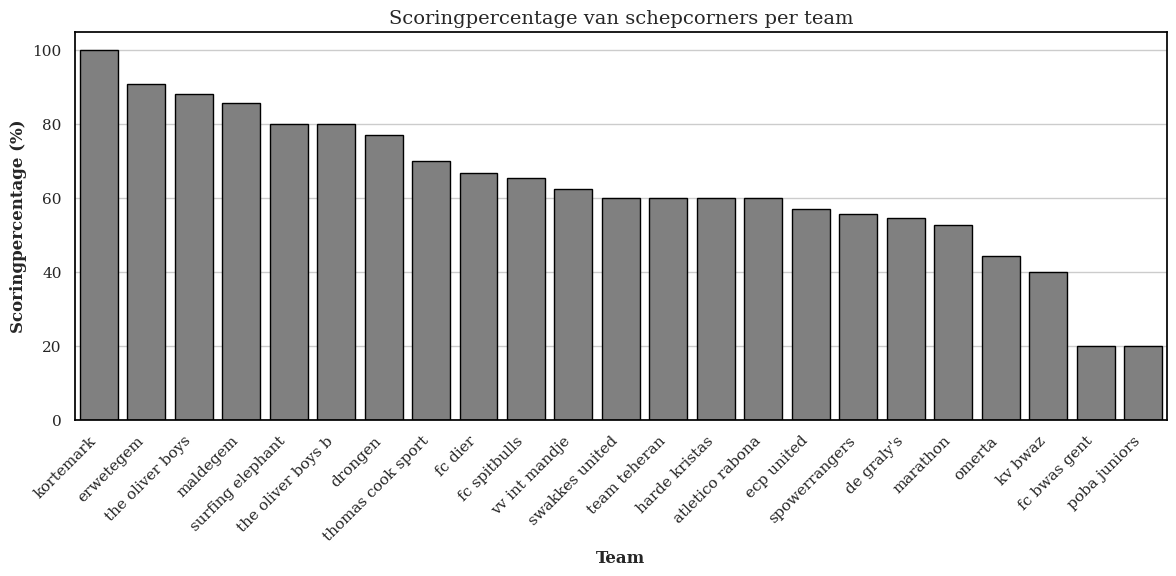

In [187]:
### we zien dat er een heel grote verscheidenheid zit in scorepercentages, alleen ploegen met minstens 5 schepcorners zijn meegenomen
# Plotten van de resultaten
plt.figure(figsize=(12, 6))
sns.barplot(data=team_stats[team_stats["totaal_schepcorners"] >= 5], x="ploegnaam", y="scoring_percentage", color="grey", edgecolor="black")
sns.set_theme(style="whitegrid", font_scale=1.2, rc={
        'axes.edgecolor': 'black',
        'axes.labelweight': 'bold',
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'font.family': 'serif'
    })
plt.xticks(rotation=45, ha='right')
plt.title("Scoringpercentage van schepcorners per team")
plt.xlabel("Team")
plt.ylabel("Scoringpercentage (%)")
plt.tight_layout()
plt.show()

In [191]:
# op deze teams zouden de resultaten natuurlijke een verschillende impact hebben
# teams met een laag percentage zouden dus graag zien dat er minder schepcorners zijn en teams met een hoog percentage zouden graag zien dat er meer schepcorners zijn
team_stats["goals_extra_3_per_match"] = (team_stats["corners_per_wedstrijd"] * extra_schep_3_perc*team_stats["scoring_percentage"]/100).round(2)
team_stats["goals_minder_5_per_match"] = (team_stats["corners_per_wedstrijd"] * minder_schep_5_perc*team_stats["scoring_percentage"]/100).round(2)

# we gaan uit van 26 matchen per seizoen, dus we vermenigvuldigen met 26
team_stats["goals_extra_3_per_seizoen"] = (team_stats["goals_extra_3_per_match"] * 26).round(2)
team_stats["goals_minder_5_per_seizoen"] = (team_stats["goals_minder_5_per_match"] * 26).round(2)

In [192]:
team_stats[team_stats["totaal_schepcorners"] >= 5]

,ploegnaam,aantal_wedstrijden,totaal_schepcorners,gescoord,scoring_percentage,corners_per_wedstrijd,goals_extra_3_per_match,goals_minder_5_per_match,goals_extra_3_per_seizoen,goals_minder_5_per_seizoen
100,kortemark,5,7,7.0,100.00,1.40,0.71,0.35,18.46,9.10
65,erwetegem,5,11,10.0,90.91,2.20,1.01,0.50,26.26,13.00
183,the oliver boys,11,17,15.0,88.24,1.55,0.69,0.34,17.94,8.84
108,maldegem,4,7,6.0,85.71,1.75,0.76,0.37,19.76,9.62
171,surfing elephant,3,5,4.0,80.00,1.67,0.67,0.33,17.42,8.58
184,the oliver boys b,4,5,4.0,80.00,1.25,0.51,0.25,13.26,6.50
55,drongen,6,13,10.0,76.92,2.17,0.84,0.42,21.84,10.92
185,thomas cook sport,8,10,7.0,70.00,1.25,0.44,0.22,11.44,5.72
72,fc dier,7,9,6.0,66.67,1.29,0.43,0.22,11.18,5.72
76,fc spitbulls,20,29,19.0,65.52,1.45,0.48,0.24,12.48,6.24


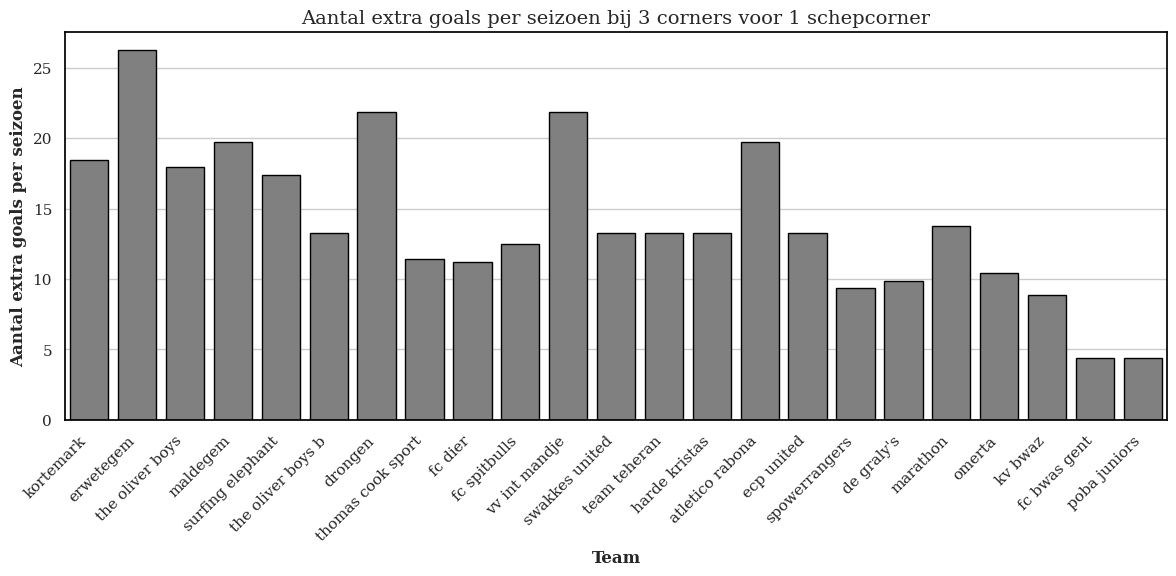

In [193]:
# Plotten van de resultaten
plt.figure(figsize=(12, 6))
sns.barplot(data=team_stats[team_stats["totaal_schepcorners"] >= 5], x="ploegnaam", y="goals_extra_3_per_seizoen", color="grey", edgecolor="black")
sns.set_theme(style="whitegrid", font_scale=1.2, rc={
        'axes.edgecolor': 'black',
        'axes.labelweight': 'bold',
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'font.family': 'serif'
    })
plt.xticks(rotation=45, ha='right')
plt.title("Aantal extra goals per seizoen bij 3 corners voor 1 schepcorner")
plt.xlabel("Team")
plt.ylabel("Aantal extra goals per seizoen")
plt.tight_layout()

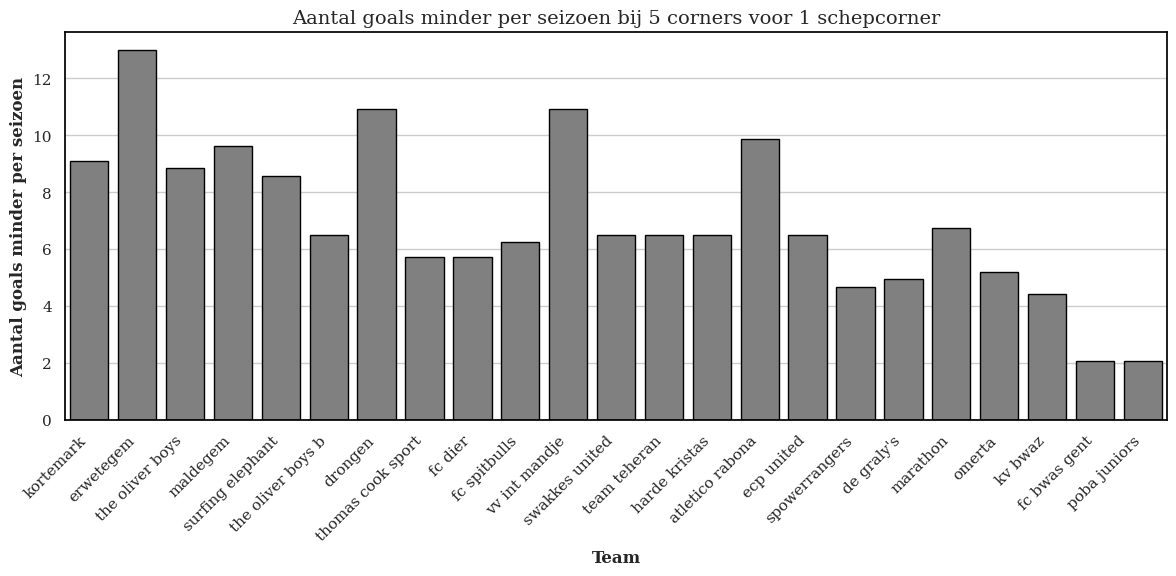

In [195]:
plt.figure(figsize=(12, 6))
sns.barplot(data=team_stats[team_stats["totaal_schepcorners"] >= 5], x="ploegnaam", y="goals_minder_5_per_seizoen", color="grey", edgecolor="black")
sns.set_theme(style="whitegrid", font_scale=1.2, rc={
        'axes.edgecolor': 'black',
        'axes.labelweight': 'bold',
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'font.family': 'serif'
    })
plt.xticks(rotation=45, ha='right')
plt.title("Aantal goals minder per seizoen bij 5 corners voor 1 schepcorner")
plt.xlabel("Team")
plt.ylabel("Aantal goals minder per seizoen")
plt.tight_layout()